In [1]:
drive_path = 'E:/'
import os
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import scipy.optimize.nnls as NNLS
from sklearn import datasets, linear_model, cross_validation, metrics
from numpy.random import rand

In [2]:
# When downloading 3D connectivity data volumes, what resolution do you want (in microns)?  
# Options are: 10, 25, 50, 100
resolution_um=25
manifest_file = os.path.join(drive_path, "MouseConnectivity","manifest.json")
mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)

# open up a pandas dataframe of all of the experiments
all_experiments = mcc.get_experiments(dataframe=True) # give the experiments
print "%d total experiments" % len(all_experiments)
ontology = mcc.get_ontology()

2279 total experiments


In [3]:
vis = ontology['VISp']
CreL = 'Cux2-IRES-Cre'
VIS_exps = mcc.get_experiments(cre=[CreL],
                                                injection_structure_ids=vis['id'],dataframe=True)
VIS_exps.head()

,gender,id,injection-coordinates,injection-structures,product-id,strain,structure-abbrev,structure-color,structure-id,structure-name,transgenic-line
id,,,,,,,,,,,
501117182,M,501117182,"[8310, 1210, 2990]","[{u'abbreviation': u'VISp', u'color': u'08858C...",36,,VISp,08858C,385,Primary visual area,Cux2-IRES-Cre
501116471,F,501116471,"[9210, 900, 2850]","[{u'abbreviation': u'VISp', u'color': u'08858C...",36,,VISp,08858C,385,Primary visual area,Cux2-IRES-Cre
483013787,M,483013787,"[9050, 780, 3140]","[{u'abbreviation': u'VISp', u'color': u'08858C...",35,,VISp,08858C,385,Primary visual area,Cux2-IRES-Cre
286302294,M,286302294,"[10140, 1410, 7880]","[{u'abbreviation': u'VISp', u'color': u'08858C...",5,B6.Cg,VISp,08858C,385,Primary visual area,Cux2-IRES-Cre
293472335,M,293472335,"[8100, 1150, 8070]","[{u'abbreviation': u'VISp', u'color': u'08858C...",5,B6.Cg,VISp,08858C,385,Primary visual area,Cux2-IRES-Cre


In [4]:
# got the projection_density/normalized volumn for the four Cre_Lines
VIS = [ 'VISal', 'VISam', 'VISl', 'VISli','VISpl', 'VISpm','VISpor']
Cre_lines = ['Cux2-IRES-Cre','Rbp4-Cre_KL100','Rorb-IRES2-Cre','Scnn1a-Tg3-Cre']
MATRIX = {}   # Connectivity matrix-->getting from least square(linear regression)
Exp_id_all = {} # get the ids for the experiments corresponding to each Cre_Line
Proj_orig = np.zeros((len(Cre_lines),len(VIS)))
vis = ontology['VISp']
structure_id_list = [float(ontology[region].id) for region in VIS]
BackgroundDensity_All = {}
for i,value in enumerate(Cre_lines):
    # take a look at what we know about an experiment with a primary visual injection for a unique creline
    CreL = value
    VIS_exps = mcc.get_experiments(cre=[CreL],
                                                injection_structure_ids=vis['id'],dataframe=True)
    
    print '%', CreL," visual experiments", len(VIS_exps)

    # contrain to only clean injections
    VIS_exps2 = VIS_exps
    L = VIS_exps2['injection-structures'].values # the injection areas
    ID = VIS_exps2['id'].values # Experiment ID
    IDnew = []
    for i in range(len(L)):
        lent = len(L[i])
        print lent
        if lent == 1:
            IDnew.append(ID[i])
    print IDnew
    print '%', CreL," visual experiments", len(IDnew)
    
    #get the injection density and background density
    visp_inj_all = mcc.get_structure_unionizes(IDnew,
                                       hemisphere_ids=[2],
                                       is_injection=True)
    visp_inj_all_background = mcc.get_structure_unionizes(IDnew,
                                       hemisphere_ids=[2],
                                       is_injection=False)
   
    BackgroundDensity = np.array([]) 
    inject_id = np.unique(visp_inj_all.experiment_id.values)
    for values_back in inject_id:
        BackgroundDensity= np.append(BackgroundDensity, 
                                     visp_inj_all_background[visp_inj_all_background.experiment_id==values_back].projection_density.sum())
    visp_proj_all = mcc.get_structure_unionizes(inject_id, 
                                       structure_ids=structure_id_list,
                                       hemisphere_ids=[2],
                                                is_injection=False)
    visp_proj_all_diff = mcc.get_structure_unionizes(inject_id, 
                                       structure_ids=structure_id_list,
                                       hemisphere_ids=[1],
                                                is_injection=False)
    
    # Injection and Projection matrix
    pd_matrix = visp_proj_all.pivot(index='experiment_id', columns='structure_id', values='projection_density')
    pd_matrix_diff = visp_proj_all_diff.pivot(index='experiment_id', columns='structure_id', values='projection_density')
    inj_matrix = visp_inj_all.pivot(index='experiment_id', columns='structure_id', values='normalized_projection_volume')
    MATRIX['Right hemisphere',CreL,'same_hemisphere'] = pd_matrix[structure_id_list]
    MATRIX['Right hemisphere',CreL,'diff_hemisphere'] = pd_matrix_diff[structure_id_list]
    MATRIX['Right hemisphere',CreL,'injection'] = inj_matrix[vis['id']]
    Exp_id_all['Right hemisphere',CreL] = inject_id
    if i == 2:
            BackgroundDensity_All[CreL] = BackgroundDensity
    print '# of experiments in right hemisphere: ', len(pd_matrix[structure_id_list])
    
    
    
    ### SIMILAR AS ABOVE PART, JUST FOR LEFT HEMISPHERE
    if CreL == 'Rorb-IRES2-Cre':
        continue
    visp_inj_all = mcc.get_structure_unionizes(IDnew,
                                       hemisphere_ids=[1],
                                       is_injection=True)
    visp_inj_all_background = mcc.get_structure_unionizes(IDnew,
                                       hemisphere_ids=[1],
                                       is_injection=False)
    inject_id = np.unique(visp_inj_all.experiment_id.values)
    for values_back in inject_id:
        BackgroundDensity= np.append(BackgroundDensity, 
                                     visp_inj_all_background[visp_inj_all_background.experiment_id==values_back].projection_density.sum())
        
    visp_proj_all = mcc.get_structure_unionizes(inject_id, 
                                       structure_ids=structure_id_list,
                                       hemisphere_ids=[1],
                                                is_injection=False)
    visp_proj_all_diff = mcc.get_structure_unionizes(inject_id, 
                                       structure_ids=structure_id_list,
                                       hemisphere_ids=[2],
                                                is_injection=False)
    pd_matrix = visp_proj_all.pivot(index='experiment_id', columns='structure_id', values='projection_density')
    pd_matrix_diff = visp_proj_all_diff.pivot(index='experiment_id', columns='structure_id', values='projection_density')
    inj_matrix = visp_inj_all.pivot(index='experiment_id', columns='structure_id', values='projection_density')
    MATRIX['Left hemisphere',CreL,'same_hemisphere'] = pd_matrix[structure_id_list]
    MATRIX['Left hemisphere',CreL,'diff_hemisphere'] = pd_matrix_diff[structure_id_list]
    MATRIX['Left hemisphere',CreL,'injection'] = inj_matrix[vis['id']]
    Exp_id_all['Left hemisphere',CreL] = inject_id
    BackgroundDensity_All[CreL] = BackgroundDensity
    print '# of experiments in left hemisphere: ', len(pd_matrix[structure_id_list])
print BackgroundDensity_All

% Cux2-IRES-Cre  visual experiments 10
1
1
1
2
1
1
1
1
3
1
[501117182, 501116471, 483013787, 293472335, 263780729, 483014695, 272821309, 183471884]
% Cux2-IRES-Cre  visual experiments 8
# of experiments in right hemisphere:  4
# of experiments in left hemisphere:  4
% Rbp4-Cre_KL100  visual experiments 8
4
1
1
1
3
1
1
1
[482578964, 266250195, 294482052, 121510421, 183173527, 272930013]
% Rbp4-Cre_KL100  visual experiments 6
# of experiments in right hemisphere:  5
# of experiments in left hemisphere:  1
% Rorb-IRES2-Cre  visual experiments 3
1
1
1
[300929973, 301616660, 287224335]
% Rorb-IRES2-Cre  visual experiments 3
# of experiments in right hemisphere:  3
% Scnn1a-Tg3-Cre  visual experiments 9
1
2
3
1
4
1
2
1
1
[166326736, 184074388, 182089608, 166269819, 479085232]
% Scnn1a-Tg3-Cre  visual experiments 5
# of experiments in right hemisphere:  4
# of experiments in left hemisphere:  1
{'Cux2-IRES-Cre': array([ 0.39405026,  4.88130412,  3.66293876,  3.86700446,  3.75645305,
        1

In [5]:
# For wild type experiments, only on right hemisphere. SIMILAR AS PREVIOUS SECTION
CreL = 'Wild type'
vis = ontology['VISp']
structure_id_list = [float(ontology[region].id) for region in VIS]
VIS_exps = mcc.get_experiments(cre=False,
                                                injection_structure_ids=vis['id'],dataframe=True)  
print 'wild type visual experiments total', len(VIS_exps)
VIS_exps2 = VIS_exps
L = VIS_exps2['injection-structures'].values
ID = VIS_exps2['id'].values
IDnew = []
for i in range(len(L)):
    lent = len(L[i])
    print lent
    if lent == 1:
        IDnew.append(ID[i])
print IDnew
print '%', CreL," visual experiments", len(IDnew)

# injection 
visp_inj_all = mcc.get_structure_unionizes(IDnew,
                                     hemisphere_ids=[2],
                                       is_injection=True)
# background 
visp_inj_all_background = mcc.get_structure_unionizes(IDnew,
                                       hemisphere_ids=[2],
                                       is_injection=False)
   
BackgroundDensity = np.array([]) 
inject_id = np.unique(visp_inj_all.experiment_id.values)
print len(inject_id)

for values_back in inject_id:
    BackgroundDensity= np.append(BackgroundDensity, 
                                     visp_inj_all_background[visp_inj_all_background.experiment_id==values_back].projection_density.sum())
print 'length of BackgroundDensity', len(BackgroundDensity)
visp_proj_all = mcc.get_structure_unionizes(inject_id, 
                                       structure_ids=structure_id_list,
                                       hemisphere_ids=[2],
                                        is_injection=False)
print len(visp_proj_all)
visp_proj_all_diff = mcc.get_structure_unionizes(inject_id, 
                                       structure_ids=structure_id_list,
                                       hemisphere_ids=[1],
                                        is_injection=False)
print len(visp_proj_all_diff)
pd_matrix = visp_proj_all.pivot(index='experiment_id', columns='structure_id', values='projection_density')
pd_matrix_diff = visp_proj_all_diff.pivot(index='experiment_id', columns='structure_id', values='projection_density')
inj_matrix = visp_inj_all.pivot(index='experiment_id', columns='structure_id', values='projection_density')
MATRIX['Right hemisphere',CreL,'same_hemisphere'] = pd_matrix[structure_id_list]
MATRIX['Right hemisphere',CreL,'diff_hemisphere'] = pd_matrix_diff[structure_id_list]
MATRIX['Right hemisphere',CreL,'injection'] = inj_matrix[vis['id']]
BackgroundDensity_All[CreL] = BackgroundDensity
print '# of experiments in right hemisphere: ', len(pd_matrix[structure_id_list])
    
    

visp_inj_all = mcc.get_structure_unionizes(IDnew,
                                       hemisphere_ids=[1],
                                       is_injection=True)
visp_inj_all_background = mcc.get_structure_unionizes(IDnew,
                                       hemisphere_ids=[1],
                                       is_injection=False)
inject_id = np.unique(visp_inj_all.experiment_id.values)
for values_back in inject_id:
    BackgroundDensity= np.append(BackgroundDensity, 
                                     visp_inj_all_background[visp_inj_all_background.experiment_id==values_back].projection_density.sum())


wild type visual experiments total 32
5
3
1
2
4
1
1
2
3
2
2
3
1
2
1
1
1
3
3
1
2
1
2
1
1
1
1
1
1
1
1
1
[307558646, 309113907, 307137980, 307320960, 307593747, 307557934, 309003780, 100141219, 304586645, 100147853, 174361040, 277714322, 277616630, 277713580, 277712166, 304564721, 304585910, 304762965]
% Wild type  visual experiments 18
18
length of BackgroundDensity 18
882
882
# of experiments in right hemisphere:  18


In [6]:
MATRIX.keys()

[('Left hemisphere', 'Cux2-IRES-Cre', 'diff_hemisphere'),
 ('Left hemisphere', 'Rbp4-Cre_KL100', 'diff_hemisphere'),
 ('Right hemisphere', 'Scnn1a-Tg3-Cre', 'same_hemisphere'),
 ('Right hemisphere', 'Rorb-IRES2-Cre', 'injection'),
 ('Left hemisphere', 'Scnn1a-Tg3-Cre', 'diff_hemisphere'),
 ('Left hemisphere', 'Cux2-IRES-Cre', 'injection'),
 ('Right hemisphere', 'Rbp4-Cre_KL100', 'same_hemisphere'),
 ('Right hemisphere', 'Wild type', 'injection'),
 ('Right hemisphere', 'Scnn1a-Tg3-Cre', 'diff_hemisphere'),
 ('Right hemisphere', 'Cux2-IRES-Cre', 'injection'),
 ('Right hemisphere', 'Cux2-IRES-Cre', 'diff_hemisphere'),
 ('Left hemisphere', 'Rbp4-Cre_KL100', 'injection'),
 ('Left hemisphere', 'Rbp4-Cre_KL100', 'same_hemisphere'),
 ('Right hemisphere', 'Rorb-IRES2-Cre', 'diff_hemisphere'),
 ('Left hemisphere', 'Scnn1a-Tg3-Cre', 'injection'),
 ('Left hemisphere', 'Scnn1a-Tg3-Cre', 'same_hemisphere'),
 ('Right hemisphere', 'Wild type', 'same_hemisphere'),
 ('Left hemisphere', 'Cux2-IRES-Cre', 

0 Cux2-IRES-Cre
1 Rbp4-Cre_KL100
2 Rorb-IRES2-Cre
3 Scnn1a-Tg3-Cre
4 Wild type
[  0.00000000e+00   1.00000000e+00   2.00000000e+00   3.00000000e+00
   4.00000000e+00   5.00000000e+00   6.00000000e+00   1.34785576e-02
   5.55848321e-03   2.69359804e-02   1.49123031e-02   6.81565407e-03
   1.46673166e-02   4.72738320e-03   4.41609585e-03   4.15619730e-03
   7.27975766e-03   5.12503274e-03   7.70780695e-03   7.94464742e-03
   4.03122602e-03   7.24749608e-03   4.77878763e-03   1.85092106e-02
   7.47545030e-03   1.46310241e-02   7.21847473e-03   3.89903387e-03
   9.86832752e-03   2.85532414e-03   3.23768856e-02   1.34382536e-02
   1.71303567e-02   1.10798885e-02   4.65317190e-03   1.00856311e-02
   3.52352842e-03   1.28223042e-02   8.57040508e-03   8.90155791e-03
   7.37360411e-03   5.69317537e-03]


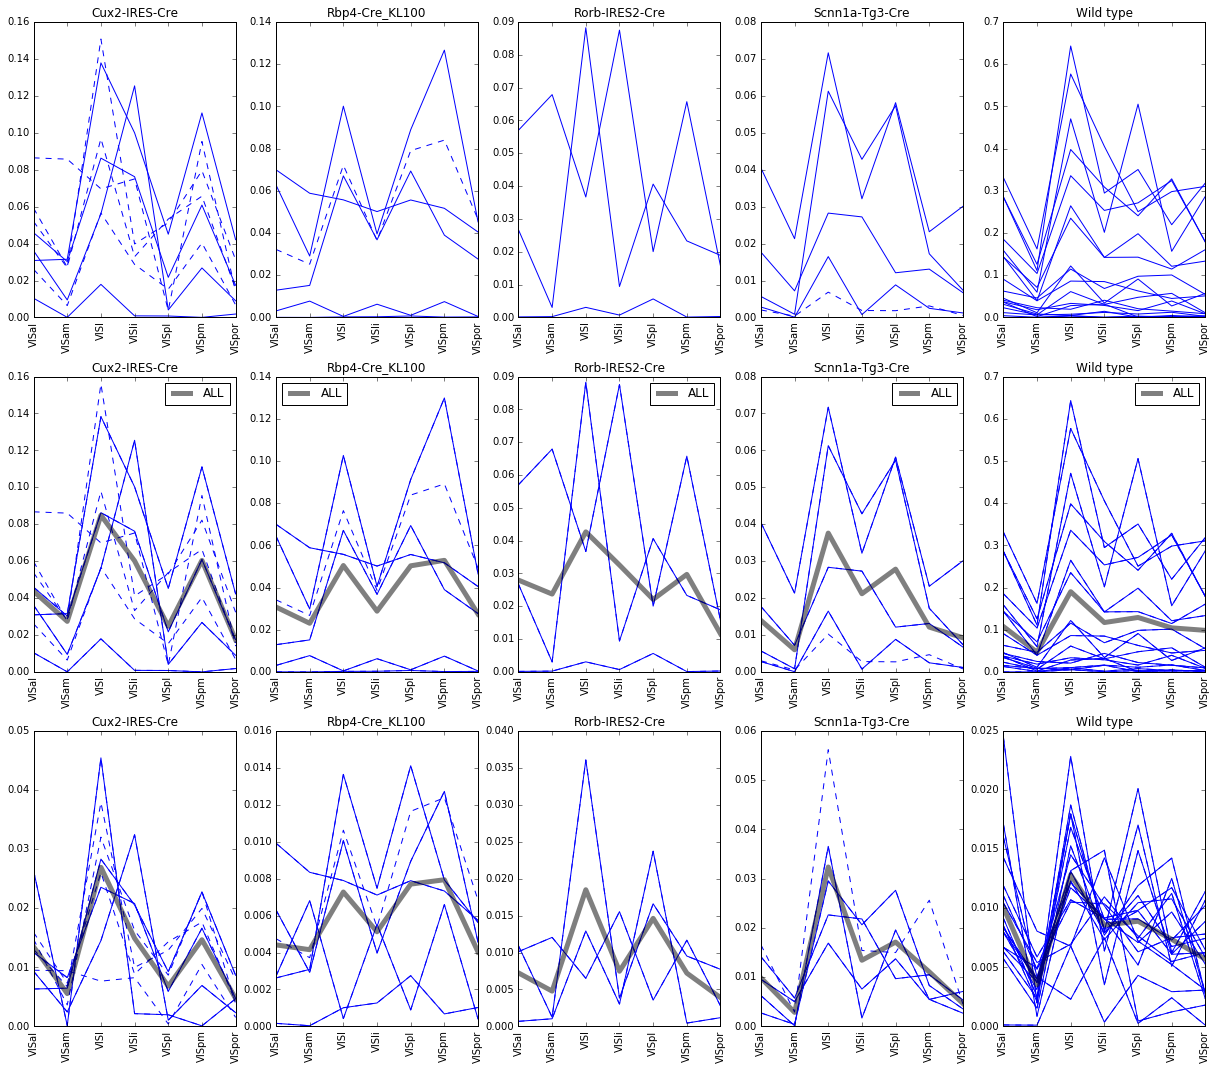

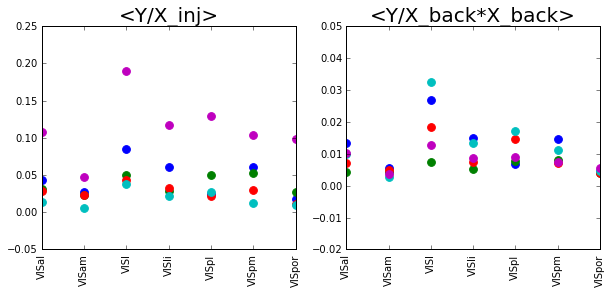

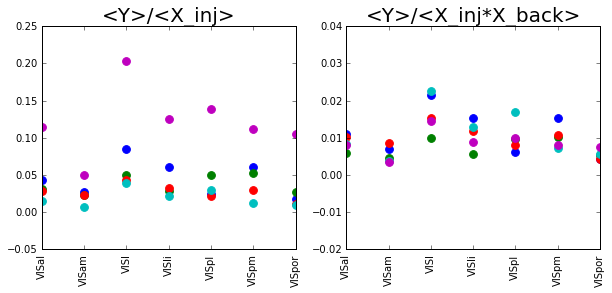

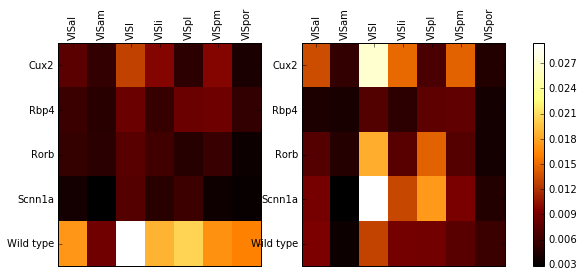

In [29]:
# This section focus on the injection--projection, and injection--projection*background
COLOR = ['b','g','r','c','m','y','k']
Cre_lines = ['Cux2-IRES-Cre','Rbp4-Cre_KL100','Rorb-IRES2-Cre','Scnn1a-Tg3-Cre','Wild type']

f, aaxx = plt.subplots(3, 5, figsize=(21,18)) #Plot projection vs. areas, projection/injection vs. areas, projection/(injection*background) vs. areas
f1, ax = plt.subplots(1,2, figsize=(10,4)) # Plot the average values after normalize over injection
F1, AX = plt.subplots(1,2, figsize=(10,4)) # Plot the average values after normalize over injection*background
F2, AX2 = plt.subplots(1,2, figsize=(10,4)) # Plot the coefficients getting from the linear regression

row_labels = ['Cux2','Rbp4','Rorb','Scnn1a','Wild type'] # these are just experiment ids
column_labels = VIS
X_default = np.array([0,1,2,3,4,5,6]);
Mean_Cre = X_default
for i, CreL in enumerate (Cre_lines):

    print i, CreL
    X_train_R = MATRIX['Right hemisphere',CreL,'injection'].values
    y_train_R = MATRIX['Right hemisphere',CreL,'same_hemisphere'].values
    len_R = len(X_train_R)
    Back = BackgroundDensity_All[CreL]
    if (i!=2) & (i!=4):
        X_train_L = MATRIX['Left hemisphere',CreL,'injection'].values 
        X_train = np.concatenate((X_train_R,X_train_L), axis=0)
        y_train_L = MATRIX['Left hemisphere',CreL,'same_hemisphere'].values
        y_train = np.concatenate((y_train_R,y_train_L), axis=0)
    else:
        X_train =X_train_R
        y_train = y_train_R
    
    
    if (i!=2) & (i!=4):
        aaxx[0][i].plot(X_default, y_train[:len_R,:].T, X_default, y_train[len_R:,:].T,'--', color = 'blue')
    else:
        aaxx[0][i].plot(X_default, y_train.T,color = 'blue')
    aaxx[0][i].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    aaxx[0][i].set_title(CreL) 
    
    BASE = np.ones([1, len(Back)])
    aaxx[1][i].plot((y_train/X_train).T,'--',color='blue')#,label = 'Left')
    aaxx[1][i].plot((y_train[:len_R,:]/X_train[:len_R]).T,color='blue')#label = 'Right')
    aaxx[1][i].plot(np.mean(y_train/X_train,axis=0), color = 'black', linewidth = 5, alpha = 0.5, label = 'ALL')
    aaxx[1][i].legend(loc='best')
    aaxx[1][i].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    aaxx[1][i].set_title(CreL)
    
    aaxx[2][i].plot((y_train/(X_train.T*Back).T).T, '--',color = 'blue')
    aaxx[2][i].plot((y_train[:len_R,:]/(X_train[:len_R].T*Back[:len_R]).T).T, color = 'blue')
    aaxx[2][i].plot(np.mean(y_train/(X_train.T*Back).T,axis=0), color = 'black', linewidth = 5, alpha = 0.5)#, label = 'ALL')
    aaxx[2][i].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    aaxx[2][i].set_title(CreL)

    
    L = np.mean(y_train/(X_train.T*Back).T,axis=0)
    Mean_Cre = np.concatenate((Mean_Cre.T, L.T), axis = 0)
    
    
    ax[0].scatter(X_default, np.mean(y_train/X_train,axis=0),s = 60, color = COLOR[i])#,label = CreL)
    ax[0].legend(loc='best')
    ax[0].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    ax[0].set_xlim([0,6])
    ax[0].set_title('<Y/X_inj>',fontsize=20)
    
    ax[1].scatter(X_default, np.mean(y_train/(X_train.T*Back).T,axis=0),s = 60, color = COLOR[i])#,label = CreL)
    ax[1].legend(loc='best')
    ax[1].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    ax[1].set_xlim([0,6])
    ax[1].set_title('<Y/X_back*X_back>',fontsize=20)
#     ax[1].scatter(X_default, np.mean(y_train/(X_train+(Back.T*BASE).T),axis=0),s = 60, color = COLOR[i],label = CreL)
#     ax[1].legend(loc='best')
#     ax[1].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
#     ax[1].set_xlim([0,6])
#     ax[1].set_title('<Y/(X_inj+X_back)>',fontsize=20)
    
    AX[0].scatter(X_default, np.mean(y_train,axis=0)/np.mean(X_train),s = 60, color = COLOR[i])#,label = CreL)
    AX[0].legend(loc='best')
    AX[0].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    AX[0].set_xlim([0,6])
    AX[0].set_title('<Y>/<X_inj>',fontsize=20)
    
   
    AX[1].scatter(X_default, np.mean(y_train,axis=0)/np.mean(X_train.T*Back).T,s = 60, color = COLOR[i])#,label = CreL)
    AX[1].legend(loc='best')
    AX[1].set_xticklabels(column_labels, minor=False , rotation = 'vertical')
    AX[1].set_xlim([0,6])
    AX[1].set_title('<Y>/<X_inj*X_back>',fontsize=20)


#     # Create linear regression object
    regr = linear_model.LinearRegression()
    regr.__init__(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
    # Train the model using the training sets
    regr.fit(X_train,y_train)
    COEF = regr.coef_
    BASE = np.ones([1,len(Back)])
    regr.fit(X_train,y_train/(BASE*Back).T)
    COEFNorm = regr.coef_

    if i == 0:
        Connect_matrix = COEF
        Connect_matrixNorm = COEFNorm
    else:
        Connect_matrix = np.c_[Connect_matrix,COEF]
        Connect_matrixNorm = np.c_[Connect_matrixNorm,COEFNorm]

matrix = Connect_matrix.T
matrixNorm = Connect_matrixNorm.T


### Y vs. X_inj (regression)
heatmap = AX2[0].pcolor(matrix, cmap=plt.cm.afmhot)
# put the major ticks at the middle of each cell
AX2[0].set_xticks(np.arange(matrixNorm.shape[1])+0.5, minor=False)
AX2[0].set_yticks(np.arange(matrixNorm.shape[0])+0.5, minor=False)
AX2[0].set_xlim([0, matrixNorm.shape[1]])
AX2[0].set_ylim([0, matrixNorm.shape[0]])          
# want a more natural, table-like display
AX2[0].invert_yaxis()
AX2[0].xaxis.tick_top()
AX2[0].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
AX2[0].set_yticklabels(row_labels, minor=False)
# AX2[0].set_title('Y vs. X_inj (regression)',fontsize=20)


### Y vs. X_inj*X_Back (regression)
heatmap = AX2[1].pcolor(matrixNorm, cmap=plt.cm.afmhot)
# put the major ticks at the middle of each cell
AX2[1].set_xticks(np.arange(matrixNorm.shape[1])+0.5, minor=False)
AX2[1].set_yticks(np.arange(matrixNorm.shape[0])+0.5, minor=False)
AX2[1].set_xlim([0, matrixNorm.shape[1]])
AX2[1].set_ylim([0, matrixNorm.shape[0]])          
# want a more natural, table-like display
AX2[1].invert_yaxis()
AX2[1].xaxis.tick_top()
AX2[1].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
AX2[1].set_yticklabels(row_labels, minor=False)
# AX2[1].set_title('Y vs. X_inj*X_Back (regression)',fontsize=20)

plt.colorbar#(ax=ax[0])
F2.colorbar(heatmap, ax=AX2.ravel().tolist())
print Mean_Cre
plt.show()

0 Cux2-IRES-Cre
8
length of BASE
1 Rbp4-Cre_KL100
6
length of BASE
2 Rorb-IRES2-Cre
3
length of BASE
3 Scnn1a-Tg3-Cre
5
length of BASE
4 Wild type
18
length of BASE
[  0.00000000e+00   1.00000000e+00   2.00000000e+00   3.00000000e+00
   4.00000000e+00   5.00000000e+00   6.00000000e+00   4.37060549e-02
   2.73891551e-02   8.48591997e-02   6.01411650e-02   2.47201502e-02
   6.04066756e-02   1.74062999e-02   3.07516217e-02   2.30617932e-02
   5.04317940e-02   2.87942616e-02   5.02899031e-02   5.28859085e-02
   2.74099987e-02   2.79736447e-02   2.37232730e-02   4.26748333e-02
   3.25608213e-02   2.21020433e-02   2.97179177e-02   1.16164497e-02
   1.39514649e-02   5.99969332e-03   3.76005703e-02   2.11701081e-02
   2.78409374e-02   1.21433380e-02   9.24863082e-03   1.07663786e-01
   4.67032827e-02   1.90130010e-01   1.17058264e-01   1.29041515e-01
   1.04418398e-01   9.85125680e-02]


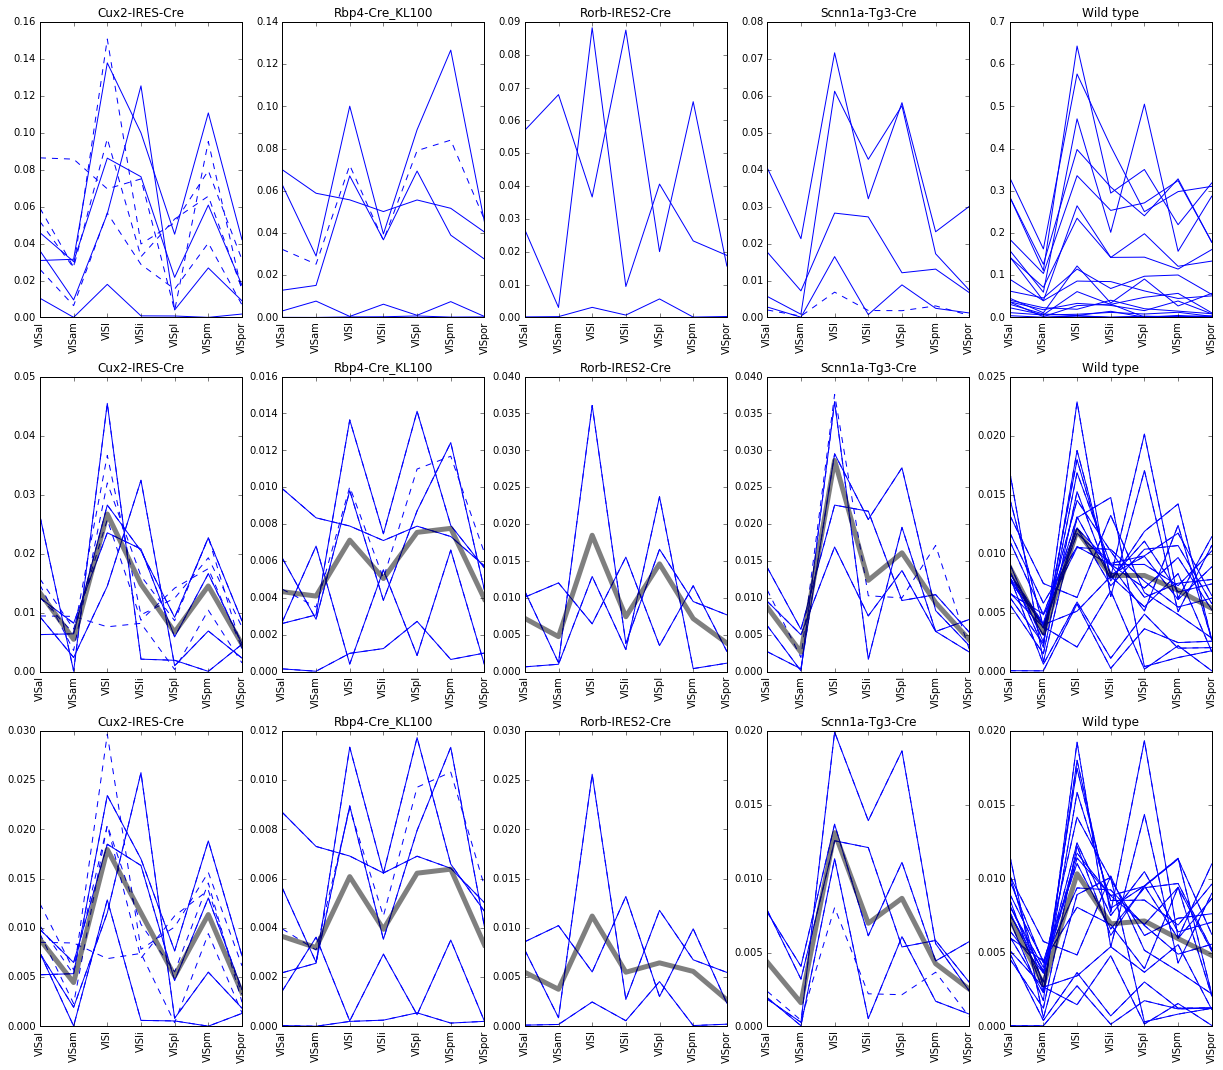

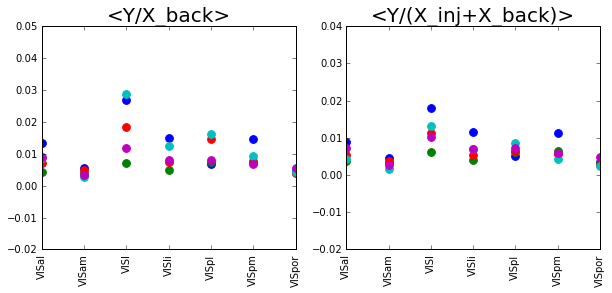

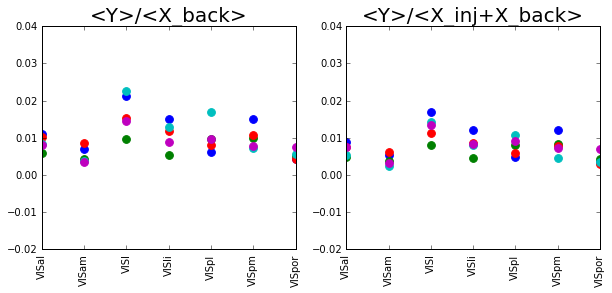

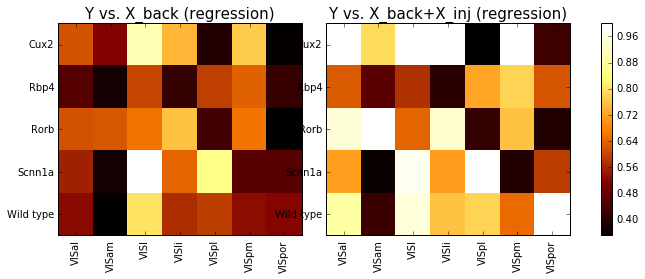

In [37]:
# This section focus on the injection--background, and injection--(projection+background)

COLOR = ['b','g','r','c','m','y','k']
Cre_lines = ['Cux2-IRES-Cre','Rbp4-Cre_KL100','Rorb-IRES2-Cre','Scnn1a-Tg3-Cre','Wild type']

f, aaxx = plt.subplots(3, 5, figsize=(21, 18)) #Plot projection vs. areas, projection/back vs. areas, projection/(injection+background) vs. areas
f1, ax1 = plt.subplots(1,2, figsize=(10,4)) # Plot the average values after normalize over background, and over background+injection
F1, AX = plt.subplots(1,2, figsize=(10,4)) # Plot the average of projection over average back, and over average back+inj
# FIG, AX = plt.subplots(1,2, figsize=(10,4))  
fig, ax = plt.subplots(1,2, figsize=(10,4)) # Plot the coefficients getting from the linear regression


row_labels = ['Cux2','Rbp4','Rorb','Scnn1a','Wild type'] # these are just experiment ids
column_labels = VIS
X_default = np.array([0,1,2,3,4,5,6]);
Mean_Cre = X_default
for i, CreL in enumerate (Cre_lines):
    print i, CreL
    X_train_R = MATRIX['Right hemisphere',CreL,'injection'].values
    y_train_R = MATRIX['Right hemisphere',CreL,'same_hemisphere'].values
    len_R = len(X_train_R)
    Back = BackgroundDensity_All[CreL]
    

    if (i!=2) & (i!=4):
        X_train_L = MATRIX['Left hemisphere',CreL,'injection'].values 
        X_train = np.concatenate((X_train_R,X_train_L), axis=0)
        y_train_L = MATRIX['Left hemisphere',CreL,'same_hemisphere'].values
        y_train = np.concatenate((y_train_R,y_train_L), axis=0)
    else:
        X_train =X_train_R
        y_train = y_train_R
        
    if (i!=2) & (i!=4):
        aaxx[0][i].plot(X_default, y_train[:len_R,:].T, X_default, y_train[len_R:,:].T,'--', color = 'blue')
    else:
        aaxx[0][i].plot(X_default, y_train.T,color = 'blue')
    
    
    aaxx[0][i].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    aaxx[0][i].set_title(CreL) 
    
    print len(Back)
    BASE = np.ones([1, len(Back)])
    print 'length of BASE'
    
    aaxx[1][i].plot((y_train/((Back.T*BASE).T)).T,'--',color='blue')
    aaxx[1][i].plot((y_train[:len_R,:]/((Back[:len_R].T*np.ones([1, len_R])).T)).T,color='blue')
    aaxx[1][i].plot(np.mean((y_train/((Back.T*BASE).T)),axis=0), color = 'black', linewidth = 5, alpha = 0.5)#, label = 'ALL')
    aaxx[1][i].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    aaxx[1][i].set_title(CreL)
    
    
    aaxx[2][i].plot((y_train/(X_train+(Back.T*BASE).T)).T,'--', color = 'blue')
    aaxx[2][i].plot((y_train[:len_R,:]/(X_train[:len_R,:]+(Back[:len_R].T*np.ones([1, len_R])).T)).T, color = 'blue')
    aaxx[2][i].plot(X_default, np.mean(y_train/(X_train+(Back.T*BASE).T),axis=0), color = 'black', linewidth = 5, alpha = 0.5)#, label = 'ALL')
    Mean2= np.mean(y_train/(X_train+(Back.T*BASE).T),axis=0)
    aaxx[2][i].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    aaxx[2][i].set_title(CreL)
    
    L = np.mean(y_train/(X_train),axis=0)
    Mean_Cre = np.concatenate((Mean_Cre.T, L.T), axis = 0)
    
    
    ax1[0].scatter(X_default, np.mean(y_train/((Back.T*BASE).T),axis=0),s = 60, color = COLOR[i])#,label = CreL)
    ax1[0].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    ax1[0].set_xlim([0,6])
    ax1[0].set_title('<Y/X_back>',fontsize=20)
    
    ax1[1].scatter(X_default, np.mean(y_train/(X_train+(Back.T*BASE).T),axis=0),s = 60, color = COLOR[i])#,label = CreL)
#     ax[1].legend(loc='best')
    ax1[1].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    ax1[1].set_xlim([0,6])
    ax1[1].set_title('<Y/(X_inj+X_back)>',fontsize=20)
    
    AX[0].scatter(X_default, np.mean(y_train,axis=0)/np.mean(((Back.T*BASE).T)),s = 60, color = COLOR[i])#,label = CreL)
#     AX[0].legend(loc='best')
    AX[0].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    AX[0].set_xlim([0,6])
    AX[0].set_title('<Y>/<X_back>',fontsize=20)
    
    AX[1].scatter(X_default, np.mean(y_train,axis=0)/np.mean((X_train+(Back.T*BASE).T)),s = 60, color = COLOR[i])#,label = CreL)
#     AX[1].legend(loc='best')
    AX[1].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
    AX[1].set_xlim([0,6])
    AX[1].set_title('<Y>/<X_inj+X_back>',fontsize=20)
    
#     # Create linear regression object
    regr = linear_model.LinearRegression()
    regr.__init__(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
    # Train the model using the training sets
    regr.fit((BASE*Back).T,y_train)
    COEF = regr.coef_
#     BASE = np.ones([1,len(Back)])
    regr.fit(X_train+(BASE*Back).T,y_train)
    COEFNorm = regr.coef_

    if i == 0:
        Connect_matrix = COEF
        Connect_matrixNorm = COEFNorm
    else:
        Connect_matrix = np.c_[Connect_matrix,COEF]
        Connect_matrixNorm = np.c_[Connect_matrixNorm,COEFNorm]
plt.tight_layout()

matrix = Connect_matrix.T
matrixNorm = Connect_matrixNorm.T

heatmap = ax[0].pcolor(matrix, cmap=plt.cm.afmhot)
# fig.colorbar(heatmap)
# put the major ticks at the middle of each cell
ax[0].set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax[0].set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)
ax[0].set_xlim([0, matrix.shape[1]])
ax[0].set_ylim([0, matrix.shape[0]])          
# want a more natural, table-like display
ax[0].invert_yaxis()
# ax[0].xaxis.tick_top()
ax[0].set_xticklabels(column_labels, minor=False, rotation = 'vertical')
ax[0].set_yticklabels(row_labels, minor=False)
ax[0].set_title('Y vs. X_back (regression)',fontsize=15)
plt.tight_layout()

heatmap = ax[1].pcolor(matrixNorm/np.max(matrixNorm,axis=0), cmap=plt.cm.afmhot)
# put the major ticks at the middle of each cell
ax[1].set_xticks(np.arange(matrixNorm.shape[1])+0.5, minor=False)
ax[1].set_yticks(np.arange(matrixNorm.shape[0])+0.5, minor=False)
ax[1].set_xlim([0, matrixNorm.shape[1]])
ax[1].set_ylim([0, matrixNorm.shape[0]])          
# want a more natural, table-like display
ax[1].invert_yaxis()
# ax[1].xaxis#.tick_top()
ax[1].set_xticklabels(column_labels, minor=False,  rotation = 'vertical')
ax[1].set_yticklabels(row_labels, minor=False)
ax[1].set_title('Y vs. X_back+X_inj (regression)',fontsize=15)
fig.colorbar(heatmap, ax=ax.ravel().tolist())


print Mean_Cre
plt.show()


In [45]:
# RANK  the  connection strength
import pandas as pd
K = Mean_Cre.reshape(6,7)
MEAN_CRE = K[1:,:]
MEAN_CRE
MEAN_Cre_all = pd.DataFrame(MEAN_CRE, index=Cre_lines, columns=VIS)

LL = np.argsort(MEAN_CRE,axis=1)
LLL = np.argsort(-1*MEAN_CRE,axis=1)

LLLL = LLL[:,:3].reshape([15,1])
K = [];
for i, values in enumerate(LLLL):
    K.append(VIS[values])
KK = zip(*[iter(K)]*3)
HHH = pd.DataFrame(KK, index=Cre_lines, columns=['Strongest','2nd Strong','3rd Strong'])
# title('Strong projections VS Cre_lines')
HHH.head()

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


,Strongest,2nd Strong,3rd Strong
Cux2-IRES-Cre,VISl,VISpm,VISli
Rbp4-Cre_KL100,VISpm,VISl,VISpl
Rorb-IRES2-Cre,VISl,VISli,VISpm
Scnn1a-Tg3-Cre,VISl,VISpl,VISli
Wild type,VISl,VISpl,VISli


In [46]:
# get the template for the brain
template, template_info = mcc.get_template_volume()
injection = ontology['VISp']
injection_mask, _ = mcc.get_structure_mask(injection['id'])
# projection = ontology['VISal']
structure_id_list = [float(ontology[region].id) for region in VIS]

EXP = Exp_id_all.values()
Exp_index = EXP[1][1]    # Rorb Right , can change the parameter to change the creline
Exp_keys = 'Rorb Right'  #Exp_id_all.keys()

Rorb Right Experiment is: 
300929973
{u'space origin': ['0', '0', '0'], u'space directions': [['25', '0', '0'], ['0', '25', '0'], ['0', '0', '25']], u'sizes': [528, 320, 456], u'space': 'left-posterior-superior', u'encoding': 'gzip', u'keyvaluepairs': {}, u'endian': 'little', u'kinds': ['domain', 'domain', 'domain'], u'type': 'float', u'dimension': 3}
((528L, 320L, 456L), (528L, 320L, 456L))
i, j, k are:
342 74 382
i, j, k are:
312 27 314
i, j, k are:
347 76 380
i, j, k are:
347 75 383
i, j, k are:
411 90 366
i, j, k are:
313 35 314
i, j, k are:
389 111 397


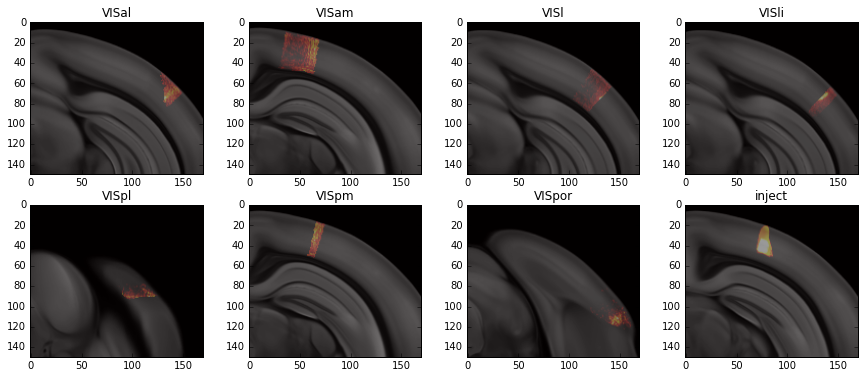

In [47]:
# PLOT　INJECTION　and PROJECTION
# def plot_inj_proj(Exp_index, Exp_keys):
print Exp_keys, 'Experiment is: \n', Exp_index
# projection density: number of projecting pixels / voxel volume
pd, pd_info = mcc.get_projection_density(Exp_index)
# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(Exp_index)
# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(Exp_index)
# annot, annot_info = mcc.get_annotation_volume()
print(pd_info)
print(pd.shape, template.shape)#, annot.shape)

# pull out the values of all voxels in the isocortex mask, mask means true inside
COMBINJ = ind*injection_mask
i,j,k= np.unravel_index(COMBINJ.argmax(), pd.shape)
f, ax = plt.subplots(2, 4, figsize=(15, 6))
ax[1][3].imshow(template[i,0:150,250:420], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ax[1][3].imshow(ind[i,0:150,250:420]*injection_mask[i,0:150,250:420],alpha=0.3, cmap='hot', aspect='equal')
ax[1][3].set_title("inject")
for L, proj_value in enumerate(structure_id_list):
    projection_mask, _ = mcc.get_structure_mask(structure_id_list[L])
    COMB = projection_mask*pd;
    i,j,k= np.unravel_index(COMB.argmax(), pd.shape)
    print 'i, j, k are:\n', i, j, k
    ax[L/4][L-L/4*4].imshow(template[i,0:150,250:420], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
    ax[L/4][L-L/4*4].set_title(VIS[L])
    ax[L/4][L-L/4*4].imshow(pd[i,0:150,250:420]*projection_mask[i,0:150,250:420],alpha=0.3, cmap='hot', aspect='equal')

plt.show()


In [ ]:
NNLS # another method to do the linear regression